# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** Wei JIANG, Minghui SHI, Costanza VOLPINI 

**Due date:** 27.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [2]:
# Additional imports
import numpy as np;
import matplotlib.pyplot as plt
%matplotlib inline

# scipy
from scipy import ndimage
from scipy.stats import mode
from scipy.ndimage import grey_erosion, grey_dilation
import scipy.ndimage as ndimage
from scipy.stats import mode

# sklearn
from sklearn.cluster import KMeans, MeanShift

# opencv
import cv2 # OpenCV library
from cv2 import adaptiveThreshold
from cv2 import fillPoly


# skimage
import skimage.io
import skimage.viewer
import skimage.measure
from skimage.color import rgb2hsv, hsv2rgb
import skimage.segmentation as seg
from skimage import feature
from skimage import measure
from skimage.morphology import disk
from skimage.filters import rank

/home/wei/anaconda3/lib/python3.7/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


### Helper functions

In [3]:
def threshold(t1, t2, img):
    '''  
     Args:
            t1 (number): lower threshold
            t2 (number): higher threshold
            img (image): image to threshold

        Returns:
            (image): binary image with values of 1 at pixels between the 2 thresholds and 0 elsewhere
    '''
    th_img = img.copy()
    th_img[th_img < t1] = 0
    th_img[th_img > t2] = 0
    th_img[(th_img >= t1) & (th_img <= t2)] = 1
    return th_img

#TODO: check return
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    '''  
     Args:
            img (image): input image
            nrows (number): number of rows
            ncols (number): number of columns
            cmap (string): display setting (e.g. grayscale)

        Returns:
            (image): image to show
            (axis): axis setted
    '''
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4, 4))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

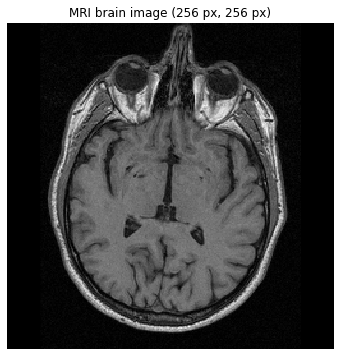

In [4]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### Histogram visualization
We started with plotting the historgram fo the original image as shown below. From the first histogram it is clear that the highest energy comes from the dark background. To take a closer look at the foreground distribution we plotted the second histogram excluding the darkest pixels.

From the second histogram we observed a big peak between 50 and approximately 90. The distribution is not bimodal, suggesting the brain and the skull is not easily separable by intensity thresholding. We therefore resorted to other methods described below.

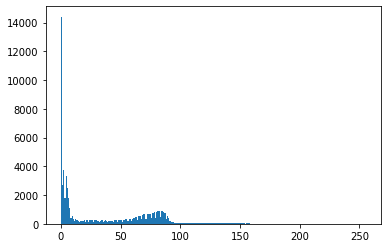

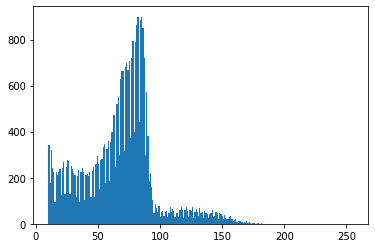

In [5]:
# histogram
plt.hist(brain_im.ravel(), 256,[0,255]);
plt.show()
plt.hist(brain_im.ravel(), 246,[10,255]);
plt.show()

### 1.2 Region growing
Add your implementation and discussion

#### Method: Region Growing to segment the image and get the brain area
We implemented a function which supports 8-connected region growing. By assinging a seed inside the region we need to segment, we could get the region. Also, we used a Gaussian filter to smooth the image as preprocessing in oder to denoise.

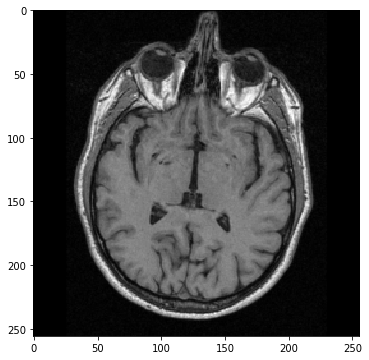

In [6]:
# Pre-processing: denoise image by Gaussian Blur
brain_denoise = cv2.GaussianBlur(brain_im,(5,5),0.5,0.5)
plt.figure(figsize=[6,6])
plt.imshow(brain_denoise,cmap='gray')

The brain size is  16023


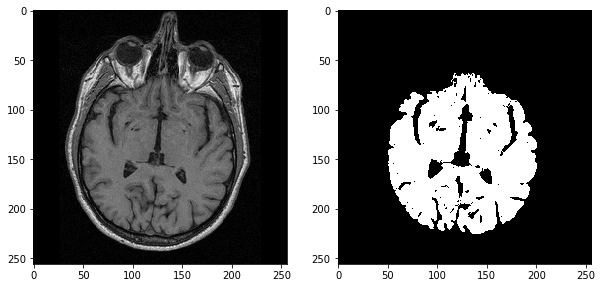

In [7]:
# region growing function
def region_growing(img, seed, threshold):
    '''  
     Args:
            img (image): input image
            seed (list): list of 2 numbers
            threshold (number): value used to threshold

        Returns:
            (image): segmented image (white region, black background)
            (number): size of the region
    '''

    img = np.float32(img)
    
    # 8-connected growing method
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1),(-1,-1),(-1,1),(1,1),(1,-1)]
    region_size = 1
    neighbor_points_list = []
    neighbor_points_list.append(seed)
    
    #Initialize segmented output image
    height,width = img.shape
    segmented_img = np.zeros((height, width), np.uint8)
    
    while len(neighbor_points_list) != 0:  
        
        seed = neighbor_points_list.pop(0)
        for i in range(8):
            
            #Compute the neighbor pixel position
            x_new = seed[0] + neighbors[i][0]
            y_new = seed[1] + neighbors[i][1]
            
            checkout = (x_new >= 0) & (y_new >= 0) & (x_new < height) & (y_new < width)
            if checkout:
                if segmented_img[x_new, y_new] == 0:
                    
                    # compute difference
                    difference = np.abs(img[x_new,y_new]-img[seed[0],seed[1]])
                    
                    if difference <= threshold:
                        
                        neighbor_points_list.append([x_new,y_new])
                        segmented_img[x_new, y_new] = 255
                        region_size+=1
                        
    return segmented_img,region_size

# set seed choosing one inside brain
seed = [153,82]
segmented_img, region_size = region_growing(brain_denoise, seed, 4)
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(brain_im, cmap='gray')
ax[1].imshow(segmented_img,cmap='gray')
print("The brain size is ",region_size)
plt.show()

### 1.3 Contour detection
Add your implementation and discussion

#### Method: Select largest continuous contour
To segment the brain using a contour detection, we tried the following sequence of operations that consists of selecting the largest contour with the use of pre-processing and post-processing methods. The image was first grayscale eroded for removing its high-intensity structures such as the skull bone because the process is similar to a minimum filter. Next, a simple threshold was applied to the image to remove very dark and black parts of the input image. A circle was then drawn around the brain that we want to segment. In this way, we can also have visual feedback to see if we are selecting the correct part to segment. After optimizing the parameters for our circle, we iterated over image pixels and set pixels outside of the circle to white, which is the background color. Next, we thresholded the image again since we wanted to have a binary image (foreground and background). With the image thresholded, we were able to find all contours at a constant value. We selected the largest contiguous contour that corresponds precisely to the brain that we want to segment. 

To compute the area of the brain, we created a separate image of the brain contour and then filled it to create a binary mask. The mask was then applied to the original image and the masked image was thresholded to preserve the brain tissue as much as possible while removing pixels in the "holes" inside the brain. Last, to get the area of the brain, we summed up the binary pixels.

Visually the final segmentation result looks acceptable. The brain's outer contour is especially well defined. There are, however, some residual pixels in the "holes" inside the brain. Increasing the lower threshold of the last thresholding operation could help with this but then the trade-off is to lose some additional brain pixels. Additionally, the contour at the back of the brain seems to leave out some of the gray matter of the brain, explaining why the brain pixel count is relatively low.

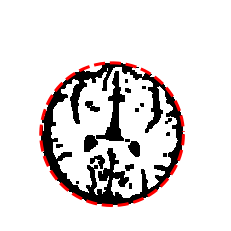

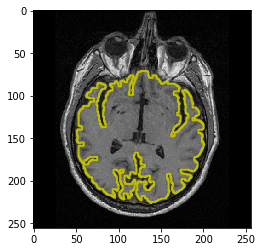

Brain area is:  15183.0


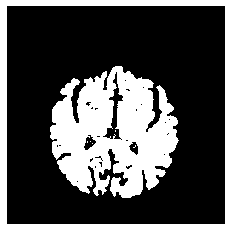

In [8]:
# 1. Morphological operator: erosion can be seen as a min filter
brain_processing = grey_erosion(brain_im, size = (4,4))

# 2. Simple to threshold to remove dark/black parts
brain_processing[brain_processing < 50] = 0

# 3. Draw a circle around the brain that we want to segment in order to have the background white
def circle_points(resolution, center, radius):
    '''  
     Args:
            resolution (image): number of points
            center (list): center of the circle
            radius (number): radius of the circle

        Returns:
            (image): circle composed by points
    '''
    radians = np.linspace(0, 2 * np.pi, resolution)
    c = center[1] + radius * np.cos(radians) 
    r = center[0] + radius * np.sin(radians)
    
    return np.array([c, r]).T


# Exclude the last point to avoid duplicate points
xc = 123
yc = 150
radius = 84
points = circle_points(200, [yc, xc], radius)[:-1]

fig, ax = image_show(brain_processing)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)

# 4. Iterate over image pixels and assign pixels outside the circle as background (white)
for y in range(brain_processing.shape[0]):
    for x in range(brain_processing.shape[1]):
        if ((x - xc) ** 2 + (y - yc) ** 2) > radius ** 2:
            brain_processing[y][x] = 255;

# 5. Threshold
# If we print the histogram we can see that we have values at 0, 255 and between 30 and 100, therefore we want just to got
# 2 values
brain_processing[brain_processing > 30] = 90

plt.imshow(brain_processing, 'gray')
plt.show()

# 6. Find contours at constant value 0.8
contours = measure.find_contours(brain_processing, 0.8)

# Select the largest contiguous contour
contour = sorted(contours, key=lambda x: len(x))[-1]

fig, ax = plt.subplots()
ax.imshow(brain_im, cmap='gray')
X, Y = ax.get_xlim(), ax.get_ylim()
ax.step(contour.T[1], contour.T[0], linewidth=2, c='y')
ax.set_xlim(X), ax.set_ylim(Y)
plt.show()

# 7. We want now to compute the area of the brain (area inside contour)
mask_m1 = np.zeros_like(brain_im, dtype='bool') # create mask

# create contour img
mask_m1[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1

# fill hole of the contour img
mask_m1 = ndimage.binary_fill_holes(mask_m1)

# 8. Create a mask and threshold to get internal parts of brain
img_mask = brain_im * mask_m1

i_thresholded = threshold(50, 255, img_mask.astype(np.float))
fig, ax = image_show(i_thresholded)

# 9. Count pixels
area_brain_tot = np.sum(i_thresholded) # count True in the mask (= pixels of the brain)
print("Brain area is: ", area_brain_tot)

### 1.4 Additional method(s)
Add your implementation and discussion

#### Method: Thresholding, morphological operators, labeling
The original image was first thresholded to get rid of as much skull as possible. Then the result was binary eroded to separate the brain from the skull bone. As the brain was the largest connected component apart from the background, it was extracted with a labeling algorithm by taking the mode of labels excluding 0 (the background is labeled 0 by the algorithm as the first pixel of the image is in the background). Lastly a binary dilation was applied to restore some brain pixels lost in the erosion and the binary pixels were summed up to yield the brain area.

The final result looks decent without significant artifacts inside the brain. The contour is not as smooth as the result from contour detection method above. 

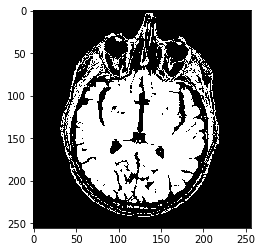

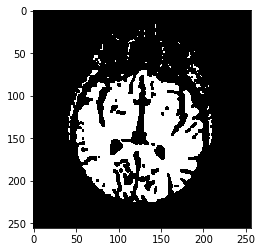

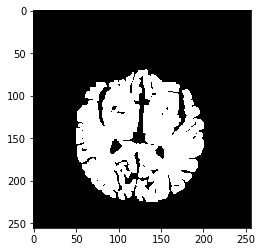

brain area is:  15846


In [9]:
# initial threshold
i_thresholded = threshold(55, 100, brain_im)

# morphological operator kernel
kernel = np.ones((3,3), np.uint8) 

# erosion to separate brain from skull
img_erosion = ndimage.binary_erosion(i_thresholded, kernel, iterations=1) 
plt.imshow(i_thresholded, cmap='gray')
plt.show()
plt.imshow(img_erosion, cmap='gray')
plt.show()

# label features
labeled_array, num_features = ndimage.label(img_erosion)

# find brain region = largest connected components
brain_region_label,_ = mode(labeled_array[labeled_array!=0])

# isolate brain region
brain_region = np.where(labeled_array != brain_region_label.item(), 0, img_erosion)

kernel3 = np.ones((3, 3), np.uint8)

# dilation to restore pixels lost in erosion
brain_region_restored = ndimage.binary_dilation(brain_region, kernel3, iterations=1) 

plt.imshow(brain_region_restored, cmap='gray')
plt.show()

print("brain area is: ", np.sum(brain_region_restored))


###### Hybrid method: Thresholding, morphological operators, labeling 

Similar to the previous method, this method includes a series of operations and it is inspired by the work of Somasundarm et al.(reference at the end of this report). 

The image was first blurred in order to get a rough mask of the brain to be extracted. The mask was then applied to the brain image denoised by the Gaussian filter. 

Next, gray-level erosion was applied to the masked denoised brain image with a flat structuring element. Gray-level erosion was used here because our goal is to get rid of the high-intensity bone structures close to the eyes by taking the local minimum.  The structuring element's shape and gray level were empirically optimized. After the erosion the image was thresholded so that in the resultant binary image majority of the bones is removed.

As there were still some tiny connecting parts between the brain and skull bone, we applied a binary erosion with a small structuring element, just enough to separate the connections.

After the brain was disconnected from other unwanted parts, we saw that now the brain is the largest connected component apart from the background. With a labeling algorithm we extracted pixels belonging to the brain. Because we know the background is labeled 0 by the algorithm (first pixel of the image is in the background), by taking the mode of labels excluding 0 we should get the brain.

With the brain isolated, the last step was to restore some pixels lost in the binary erosion step, especially pixels around those "holes" inside the brain. The restoration was done by applying a binary dilation with the same structuring element as the previous erosion.

All binary pixels of the processed image were summed up to generate the number of pixels in the brain.

Visually this result looks good without significant artifact inside the brain. The contour is still not as smooth as the result from contour detection method, however.


In [10]:
# Denoise with Gaussian filter
brain_denoise = cv2.GaussianBlur(brain_im,(5,5),0.5,0.5)

# blur the image by local mean filtering with circular element
selem = disk(40)
brain_blur = rank.mean(brain_im, selem=selem)

# find a rough mask of the brain with thresholding
i_thresholded = threshold(45, 95, brain_blur)
plt.imshow(brain_denoise*i_thresholded, cmap='gray')
plt.show()

# gray level erosion with structuring element of gray level 99 (empirically optimized)
kernel = np.ones((11,11), np.uint8)*99
rough_mask = brain_denoise*i_thresholded
img_erosion = ndimage.grey_erosion(rough_mask,structure=kernel)
plt.imshow(img_erosion, cmap = 'gray')
plt.show()

# thresholding to extract the brain tissue and use binary erosion to separate the brain tissue from other unwanted pixels
i_thresholded = threshold(210, 255, img_erosion.astype(np.float))
kernel2 = np.ones((3,1), np.uint8)
img_erosion2 = ndimage.binary_erosion(i_thresholded, kernel2, iterations=1).astype(i_thresholded.dtype) 
plt.imshow(img_erosion2, cmap='gray')
plt.show()

# apply labeling algorithm
labeled_array, num_features = ndimage.label(img_erosion2)
# find the largest connecting component excluding the background
brain_region_label,_ = mode(labeled_array[labeled_array!=0]) 
brain_region = np.where(labeled_array != brain_region_label.item(), 0, img_erosion2)

# apply dilation to restore brain pixels that may be lost in binary erosion
brain_region_restored= ndimage.binary_dilation(brain_region, kernel2, iterations=1) 
plt.imshow(brain_region_restored,cmap='gray')
plt.show()

# sum up the binary pixels to get brain area in pixels
print("brain area is: ", np.sum(brain_region_restored), " pixels")

brain area is:  16232  pixels


#### Method: Active contours (snake)
Active contours algorithm (snake) was used to detect the outline of the brain. After some experimentation we observed that the initialization curve is critical to the performance of the contour detection. As skull bone is of higher contrast than the brain agains the background, if the curve is initialized closer to the skull the algorithm would pick up the skull outline. After trial and error the best result we got was from an elliptical initialization curve with weights alpha, beta, gamma as shown below. From the plot, however, we can see that even this contour (blue curve blow) is still not optimal.

A mask was created using the detected contour. As the snake's output becomes disconnected points after rounding, a binary dilation was applied to connect the points so that the contour could be filled. The original image was masked and thresholded with the 2-threshold function. All binary pixels was summed up to yield the result of brain area.

It is clear from the thresholded image plot that the final result is an overestimation because there are some residual skull bone structures still connected to the brain due to the suboptimal performance of active contours.


In [11]:
# 1. Initialize an ellipsoid curve
def ellipse_points(resolution, center, radius, a, b):
    '''  
     Args:
            resolution (image): number of points
            center (list): center of the ellipse
            radius (number): radius of the ellipse
            a: scaling coefficient
            b: scaling coefficient

        Returns:
            (image): ellipse composed by points
    '''
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + a*radius*np.cos(radians)
    r = center[0] + b*radius*np.sin(radians)
    return np.array([c, r]).T

points = ellipse_points(300, [147, 125], 80,0.98,1.03)[:-1]

# 2. Detect edges with canny algorithm
edges = skimage.feature.canny(
    image=brain_im,
    sigma=.8,
    low_threshold=55,
    high_threshold=90,
)

# 3. Apply snake on the canny image
# weighting parameter notes
# alpha = 1st derivative: elongation
# beta = 2nd derivative: curvature
# gamma =  attraction to contour
snake = seg.active_contour(edges, points, alpha=1.2, beta=0.6, gamma=0.02)

fig, ax = image_show(brain_im)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

# 4. Mask image with the contour

mask = np.zeros_like(brain_im)
# Create a contour image by using the contour coordinates rounded to their nearest integer value
mask[np.round(snake[:, 1]).astype('int'), np.round(snake[:, 0]).astype('int')] = 1

# Use dilation to connect the points on the contour
kernel = np.ones((2,2), np.uint8)
mask = ndimage.binary_dilation(mask, kernel, iterations=1)

# Fill in the hole created by the contour boundary
mask = ndimage.binary_fill_holes(mask)

im_masked = mask*brain_im

# 5. Apply threshold on masked image
i_thresholded = threshold(55, 255, im_masked.astype(np.float))
fig, ax = image_show(i_thresholded)
# sum up the binary pixels to get brain area in pixels
print("brain area is: ", np.sum(i_thresholded), " pixels")

brain area is:  561.0  pixels


TODO: ? 
As shown in the following table, we can see that all the results are tolerably close to each other. With the Largest Continuous method we have got a smaller area of the brain. As opposed with the Snake method  that has returned larger value. We don't know which one of the methods tested have performed better since we don't know if the internal part of the brain must be counted as "brain area". 

| Method                                                | Area in pixels |
|-------------------------------------------------------|----------------|
| Region Growing                                        | 16117          |
| Largest continuous contour with pre/post-processing   | 15183          |
| Threshold, morphological operators, labeling          | 15846          |
| Threshold, morphological operators, labeling (hybrid) | 16272          |
| Snake                                                 | 16347          |

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [12]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)
    
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
# Load image
data_path = os.path.join(data_base_path, data_folder)
    
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


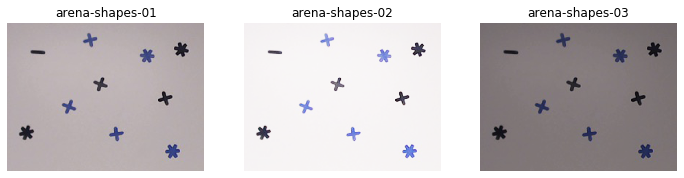

In [13]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

##### Adaptive Thresholding to Segment Objects
We used adaptive thresholding method to separate foreground from background and used this as our mask to segment the objects. We observed that adaptive thresholding is robust and has good performance for all intensity images.

In [14]:
# object mask from adaptive threshoulding
masks = []
for img in images:
    
    # convert to binary image to threshold
    image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # using adaptive gaussian to get robust mask
    mask = (1-cv2.adaptiveThreshold(image,1,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,101,5))
#     mask = ndimage.median_filter(mask, size = 3)
    kernel = np.ones((4,4), np.uint8)
    mask = ndimage.binary_opening(mask, kernel, iterations=1) 
    masks.append(mask)

# print image
print("The mask for forground: ")
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), masks, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()


The mask for forground: 


##### Normalize intensity and white balance
To make our algorithm robust to illumination changes, we preprocessed the images by normalizing the intensity and performing white balance. The images were transformed to HSV map and objects were segmented by applying the foreground masks generated in the last step. The image's third HSV channel, which is lightness, was normalized subtracting the mean and dividing by the range of the foreground's lightness. The result was clipped to the range of [0.0,1.0] and transformed back to RGB.

A median filter was applied because some salt and pepper noise was observed. Then the image's RGB channel was passed to the white balance function respectively. The function clips the highest and lowest given percentage (0.5 was used in our case) of each channel's values off and rescales the range to [0, 255].

As shown in the plot, the 3 images look more similar after intensity normalization and white balance.

In [15]:
def norm_intensity(img,mask):
    '''  
     Args:
            img (image)
            mask: binary mask

        Returns:
            output (image): image after intensity normalization
    '''
    imghsv = rgb2hsv(img)
    # apply foreground mask
    fg = imghsv[:,:,2]*mask
    # normalize intensity
    imghsv[:,:,2] = (imghsv[:,:,2] - fg.min())/(fg.max()-fg.min())  
    # convert image back to 
    out = hsv2rgb(imghsv)
    out[out > 1] = 1
    out[out < 0] = 0
    return out

# white balance
def wb(channel, perc):
    '''  
     Args:
            channel: image channel
            perc: percentage to be clipped off

        Returns:
            channel: image channel after white balance
    '''
    mi, ma = (np.percentile(channel*(mask), perc), np.percentile(channel*(mask),100.0-perc))
    channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
    return channel
fig, axes = plt.subplots(1, 3, figsize=(12, 12))

plt.imshow(mask)

im_normed = []
for ax, im  in zip(axes.ravel(), images):
    im_norm = norm_intensity(im,mask)
    im_norm = ndimage.median_filter(im_norm,size =3)
    im_norm  = np.dstack([wb(channel, 0.5) for channel in cv2.split(im_norm)] )
    ax.imshow(im_norm)
    im_normed.append(im_norm)



/home/wei/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:271: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/home/wei/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


### 2.2 Number of shapes of each color

##### Method 1: Naive solution (threshold + morphological operators)
As a starting point to count the number of shapes of each color, we tried a naive solution.  The intensity of the foreground objects was first normalized; then white of the images was then balanced using methods in 2.1. The image was then thresholded in order to create two masks. Each one contains the respective shapes of "blue" and "black" objects. Next, different morphological operators were applied to remove undesired artifacts. With the two masks refined, we therefore counted the number of connected regions to know the number of shapes.

In [16]:
def count_objects(mask, text):
    ''' 
    Function used to count the number of shapes in an image. 
     Args:
            mask (image): binary image
            text (string): caption to print (e.g. "#Shapes in black: ")

        Returns:
            (void): print the number of connected regions with a caption.
    '''
    labels = skimage.measure.label(mask)
#     print(text, labels.max()) # just for debug
    return labels.max()
    
    
def naive_solution_black_shapes(img, mask, t1, t2):
    ''' 
    Function used to apply the naive method explained above to get black shapes. 
     Args:
            img (image): image
            t1 (number): lower threshold
            t2 (number): upper threshold

        Returns:
            (image): image containing the black shapes
            (number): number of black shapes
    '''
    # 0. Preprocessing
    img = img.copy()
    img = norm_intensity(img, mask)[:, :, 2]
    img = ndimage.median_filter(img, size = 5)
    
    # 1. Generate the mask that will contain black shapes  
    mask_black_shape = threshold(t1, t2, img)
    
    # swap black and white for morphological operator
    mask_black_shape = 1 - mask_black_shape
    
    # 2. Apply morphological operator to refine the mask
    kernel = np.ones((3,2), np.uint8)
    mask_black_shape = ndimage.binary_closing(mask_black_shape, kernel, iterations=1) 
    
    kernel = np.ones((2,2), np.uint8)
    mask_black_shape = ndimage.binary_erosion(mask_black_shape, kernel, iterations=1) 
    plt.imshow(mask_black_shape,cmap= 'gray')

    # 3. Count the number of shapes that are black
    numberShape = count_objects(mask_black_shape, "#Shapes in black: ")
    
    return mask_black_shape, numberShape

def naive_solution_blue_shapes(img, mask, t1, t2):
    ''' 
    Function used to apply the naive method explained above to get blue shapes. 
     Args:
            img (image): image
            t1 (number): lower threshold
            t2 (number): upper threshold

        Returns:
            (image): image containing the blue shapes
            (number): number of blue shapes
    '''
    # The process is analogous to the above one 
    img = img.copy()
    img = norm_intensity(img, mask)[:, :, 2]
    img = ndimage.median_filter(img, size = 5)
 
    mask_blue_shape = threshold(t1, t2, img)

    kernel = np.ones((3,3), np.uint8)
    mask_blue_shape = ndimage.binary_erosion(mask_blue_shape, kernel, iterations=1) 

    kernel = np.ones((6,6), np.uint8)
    mask_blue_shape = ndimage.binary_closing(mask_blue_shape, kernel, iterations=1) 

    kernel = np.ones((2,2), np.uint8)
    mask_blue_shape = ndimage.binary_erosion(mask_blue_shape, kernel, iterations=1) 

    plt.imshow(mask_blue_shape,cmap= 'gray')

    numberShape = count_objects(mask_blue_shape, "#Shapes in blue: ")
    
    return mask_blue_shape, numberShape


We noticed that the method proposed was not robust, as you can see in the cell below. Indeed, when it is applied to the second image the result obtained was inadequate.

# Black Shapes in  arena-shapes-01  :  5  the area is:  3836
# Black Shapes in  arena-shapes-02  :  5  the area is:  2629
# Black Shapes in  arena-shapes-03  :  5  the area is:  4036


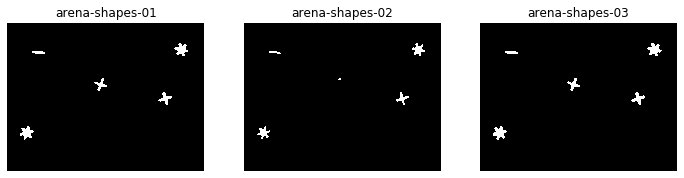

# Blue Shapes in  arena-shapes-01  :  5  the area is:  3274
# Blue Shapes in  arena-shapes-02  :  2  the area is:  406
# Blue Shapes in  arena-shapes-03  :  5  the area is:  3850


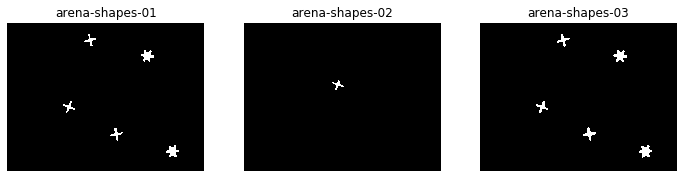

In [17]:
# test robustness
# Black shape
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm, mask in zip(axes.ravel(), images, im_names, masks):
    im , counter = naive_solution_black_shapes(im, mask, 0.42, 1.0)
    ax.imshow(im, 'gray')
    ax.axis('off')
    ax.set_title(nm)
    print("# Black Shapes in ", nm," : ", int(counter), " the area is: ", im.sum())
plt.show() 


# Blue shape
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm, mask in zip(axes.ravel(), images, im_names, masks):
#     im , counter = naive_solution_blue_shapes(im, mask, 0.6, 0.9) #just 2nd
    im , counter = naive_solution_blue_shapes(im, mask, 0.4, 0.68)
    ax.imshow(im, 'gray')
    ax.axis('off')
    ax.set_title(nm)
    print("# Blue Shapes in ", nm," : ", int(counter), " the area is: ", im.sum())
plt.show() 

##### Method 2: Kmeans and Morphorlogical Operators
Since we need to separate the colors of objects first, we can take it as a classification task. We find kmeans clustering performs very well and can separate objects from different colors and background easily. The three clusters are background, blue objects, black objects. 

After separating colors, we use midian filter to denoise and morphological operator to get robust results.

In [18]:
# Kmeans clustering method
# segment black objects
def get_black(img):
    '''  
     Args:
            img (image): image
        Returns:
            (imk): one cluster of objects in image 
            (number): number of object labels

    '''
    # set clustering as 3
    kmeans = KMeans(n_clusters=3,random_state=3).fit_predict(img.reshape(-1, 3))
    k1 = kmeans.copy()
    
    # get one cluster
    k1[k1!=1]=0
    imk = k1.reshape(img.shape[:2])
    imk = ndimage.median_filter(imk, size=5)
    
    # use cross as structure element of dialtion
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
    imk = ndimage.binary_dilation(imk, kernel, iterations=1) 
    
    # count the number of object
    all_labels = measure.label(imk)
    
    return imk, all_labels

# print image
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    im , label= get_black(im)
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
    print("# Black shape of ",nm, " : ",label.max(), " the area is: ", im.sum())
plt.show()

# Black shape of  arena-shapes-01  :  5  the area is:  5411
# Black shape of  arena-shapes-02  :  5  the area is:  5061
# Black shape of  arena-shapes-03  :  5  the area is:  5420


In [19]:
# Kmeans clustering method
# segment blue objects
def get_blue(img):
    '''  
     Args:
            img (image): image
        Returns:
            (imk): one cluster of objects in image 
            (number): number of object labels

    '''
    # set clustering as 3
    kmeans = KMeans(n_clusters=3,random_state=3).fit_predict(img.reshape(-1, 3))
    k1 = kmeans.copy()
    
    # get one cluster
    k1[k1!=2]=0
    imk = k1.reshape(img.shape[:2])
    imk = ndimage.median_filter(imk, size=5)
    
    # use cross as structure element of opening
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(7,7))
    imk = ndimage.binary_opening(imk, kernel, iterations=1) 
    
    # count the number of object
    all_labels = measure.label(imk)
    
    return imk, all_labels

# print image
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):  
    im , label= get_blue(im)
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
    print("# Blue shape of ",nm, " : ",label.max()," the area is: ", im.sum())
plt.show()

# Blue shape of  arena-shapes-01  :  5  the area is:  5121
# Blue shape of  arena-shapes-02  :  5  the area is:  4461
# Blue shape of  arena-shapes-03  :  5  the area is:  5235


##### Method 3: Adaptive Thresholding, Labeling, and Kmeans

Because we observed that K means algorithm tends to misclassify pixels at the edge of the objects, we decided to use the foreground mask generated by adaptive thresholding previously to get a cleaner classification.

We applied the foreground mask to K means result and labeled every objects. Then we went through each object and relabel all pixels within the object by the mode of Kmeans classification results within the object. This way the outlier pixels at the edge were "outvoted" by the majority and we were able to get satisfactory results.

We did not use the preprocessed images here because it is not needed with K-means. From our experimentation we actually found that K-means performs better with the original images. It appears that intensity normalization introduced some additional noise that made the saturation more uneven inside certain objects, giving the clustering algorithm a difficult time.

# Black Shape in  arena-shapes-01  :  5  the area is:  5333
# Blue Shape in  arena-shapes-01  :  5  the area is:  5671.0
# Black Shape in  arena-shapes-02  :  5  the area is:  4738
# Blue Shape in  arena-shapes-02  :  5  the area is:  5046.0
# Black Shape in  arena-shapes-03  :  5  the area is:  5392
# Blue Shape in  arena-shapes-03  :  5  the area is:  5740.0


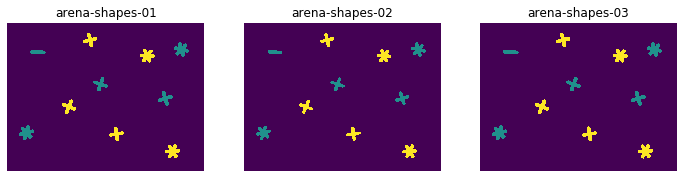

In [20]:
# combine labeling with k means
def apply_mask(kmeans, mask):    
    '''  
     Args:
            kmeans: Kmeans result
            mask: binary mask

        Returns:
            output: relabeled kmeans result
            counter: array with object counts
    '''
    imk = kmeans.reshape(mask.shape[:2])
    labeled_array, num_features = ndimage.label(mask, structure =np.ones((3,3)))
    counter = np.zeros(3)
    output = labeled_array.copy()
    for i in range(1,num_features+1):
        kmeans_label,_ = mode(imk[labeled_array==i])
        output[labeled_array == i] = kmeans_label
        counter[kmeans_label] += 1
    return output, counter
    
# print image, shape count, and area count
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm, mask in zip(axes.ravel(), images, im_names, masks):
    kmeans = KMeans(n_clusters=3,random_state=3).fit_predict(im.reshape(-1, 3))
    im , counter = apply_mask(kmeans, mask)
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
    print("# Black Shape in ", nm," : ", int(counter[1]), " the area is: ", im[im==1].sum())
    print("# Blue Shape in ",nm, " : " , int(counter[2]), " the area is: ", im[im==2].sum()/2)
plt.show() 


### 2.3 Total area (in pixels) of each color
Add your implementation and discussion

#### Solution using methods of exercise 2.2
**Naive method:** The total area of each color can be found, counting the number of pixels set to "True" (foreground).
\
\
**K-means and morhorlogical operators:** Since the objects are already clustered by color and separated, we could easily get the area by counting pixels. 
\
\
**Adaptive Thresholding, Labeling, Kmeans method:** By relabeling each object with the Kmeans clustering results, we were able to get the area of each color by summing up all pixels labed with 1 (black) and 2 (blue) respectively. For the pixel = 2 case the sum was divided by 2 so that we got number of pixels.

|     Method  color                        | black arena-shapes-01  | blue arena-shapes-01 | black arena-shapes-02 | blue arena-shapes-02  | black arena-shapes-03 | blue arena-shapes-03 |
|------------------------------------------|-----------|---------|----------|----------|----------|---------|
| Naive method (threshold and morph. oper) | 3836      |    3274     | 2629    |     -    |  4036       | 3850       |
| K-means and morhorlogical operators      | 5411      | 5121     | 5061    |4461      | 5420     | 5235    |
| K-means, Labeling, adaptive thresholding | 5333      | 5671     | 4738    |  5046    | 5392     | 5740    |


The difference of three methods is due to the background noise and the blurred boundary between objects and background. Also in the arena-shape-02, the intensity is high that makes it difficult to segment through simple thresholding. We found the adaptive thresholding with labeling is most robust to intensity since the adpative thresholding is very robust to segment the objects.

### References

- Image Segmentation using Python’s scikit-image module. https://towardsdatascience.com/image-segmentation-using-pythons-scikit-image-module-533a61ecc980
- Create mask from skimage contour https://stackoverflow.com/questions/39642680/create-mask-from-skimage-contour
-  Somasundaram, K., and P. Kalavathi. 2010. “A Hybrid Method for Automatic Skull Stripping of Magnetic Resonance Images (MRI) of Human Head Scans.” In 2010 Second International Conference on Computing, Communication and Networking Technologies, 1–5. https://doi.org/10.1109/ICCCNT.2010.5592550
- White Balance https://stackoverflow.com/questions/1175393/white-balance-algorithm